# Import

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import daft
from causalgraphicalmodels import CausalGraphicalModel
import logging

BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

def precis(trace, var_names=None):
  s = az.summary(trace, hdi_prob=0.89, round_to=2, var_names=var_names)
  return s[['mean', 'sd', 'hdi_5.5%','hdi_94.5%']]

def scale(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, disable_progress_bar=True):
    
    logger = logging.getLogger('pymc3')
    logger.setLevel(logging.ERROR)

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc3

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            testval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True, progressbar = disable_progress_bar==False)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(
        stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1)
    )

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(
        stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1)
    )

    logger.setLevel(logging.DEBUG)

    return np.mean(dev_train), np.mean(dev_test)


%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [2]:
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.api as sm
from scipy.special import logsumexp
from patsy import dmatrix

# Chapter 8

Lecutre 9: https://www.youtube.com/watch?v=QhHfo6-Bx8o&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=9&ab_channel=RichardMcElreath



All Credits go to: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_08.ipynb

## 8.1 Building an interaction

### Code 8.1

In [3]:
d = pd.read_csv(BASE_URL + '/rugged.csv', sep=';')
# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)
# extract countries with GDP data
dd = d.dropna(subset=['rgdppc_2000']).copy()
# rescale variables
dd['log_gdp_std'] = dd['log_gdp'] / dd['log_gdp'].mean()
dd['rugged_std'] = dd['rugged'] / dd['rugged'].max()

dd.head()

isocode  isonum               country  rugged  rugged_popw  rugged_slope  \
2     AGO      24                Angola   0.858        0.714         2.274   
4     ALB       8               Albania   3.427        1.597        10.451   
7     ARE     784  United Arab Emirates   0.769        0.316         2.112   
8     ARG      32             Argentina   0.775        0.220         2.268   
9     ARM      51               Armenia   2.688        0.934         8.178   

   rugged_lsd  rugged_pc  land_area     lat  ...  slave_exports  \
2       0.228      4.906   124670.0 -12.299  ...      3610000.0   
4       1.006     62.133     2740.0  41.143  ...            0.0   
7       0.191      6.142     8360.0  23.913  ...            0.0   
8       0.226      9.407   273669.0 -35.396  ...            0.0   
9       0.799     50.556     2820.0  40.294  ...            0.0   

   dist_slavemkt_atlantic  dist_slavemkt_indian  dist_slavemkt_saharan  \
2                   5.669                 6.981                  4.926   
4                     NaN                   NaN                    NaN   
7                     NaN                   NaN                    NaN   
8                     NaN                   NaN                    NaN   
9                     NaN                   NaN                    NaN   

   dist_slavemkt_redsea   pop_1400  european_descent   log_gdp  log_gdp_std  \
2                 3.872  1223208.0             2.000  7.492609     0.879712   
4                   NaN   200000.0           100.000  8.216929     0.964755   
7                   NaN    19200.0             0.000  9.933263     1.166270   
8                   NaN   276632.0            89.889  9.407032     1.104485   
9                   NaN   105743.0             0.500  7.792343     0.914904   

   rugged_std  
2    0.138342  
4    0.552564  
7    0.123992  
8    0.124960  
9    0.433409  

[5 rows x 54 columns]

### Code 8.2

In [7]:
with pm.Model() as m8_1:
    sigma = pm.Exponential('sigma', 1)
    b = pm.Normal('b', 0, 1)
    a = pm.Normal('a', 1, 1)
    mu = a + b*(dd.rugged_std - 0.215)
    log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=dd.log_gdp_std)

    m8_1_trace = pm.sample(chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


### Code 8.3

In [ ]:
with m8_1:
    m8_1_prior = pm.sample_prior_predictive()

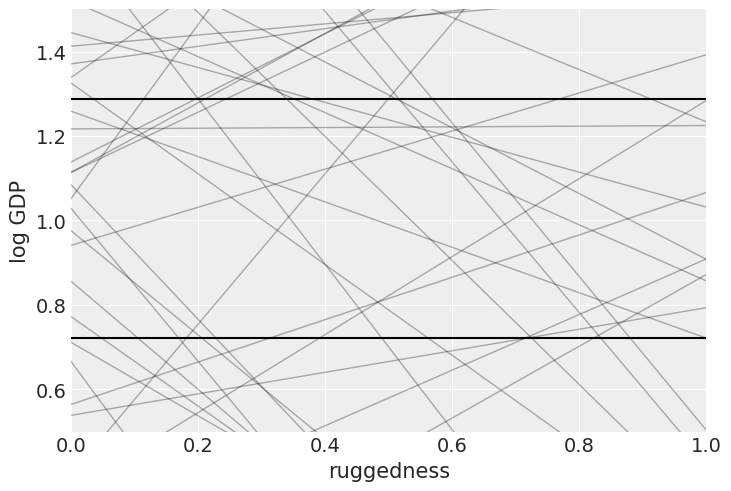

In [ ]:
n = 50
rugged_plot = np.linspace(-0.1, 1.1, num=n)
plt.plot(
    rugged_plot,
    m8_1_prior["a"][:n] + m8_1_prior["b"][:n] * rugged_plot.reshape(-1, 1),
    color="k",
    lw=1,
    alpha=0.3
)

plt.hlines(y=min(dd.log_gdp_std), xmin=-0.1, xmax=1.1)
plt.hlines(y=max(dd.log_gdp_std), xmin=-0.1, xmax=1.1)

plt.xlim([0,1])
plt.ylim([0.5, 1.5])
plt.xlabel('ruggedness')
plt.ylabel('log GDP')

plt.show()

### Code 8.4

In [ ]:
sum(abs(m8_1_prior["b"]) > 0.6) / len(m8_1_prior["b"])

0.562

### Code 8.5

In [ ]:
with pm.Model() as m8_1:
  sigma = pm.Exponential('sigma', 1)
  b = pm.Normal('b', 0, 0.3)
  a = pm.Normal('a', 1, 0.1)
  mu = a + b*(dd.rugged_std - 0.215)
  log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=dd.log_gdp_std)

  m8_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Code 8.6

In [ ]:
precis(m8_1_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
b      0.00  0.06     -0.09       0.08
a      1.00  0.01      0.98       1.02
sigma  0.14  0.01      0.13       0.15

In [ ]:
with m8_1:
  prior_m8_1 = pm.sample_prior_predictive()

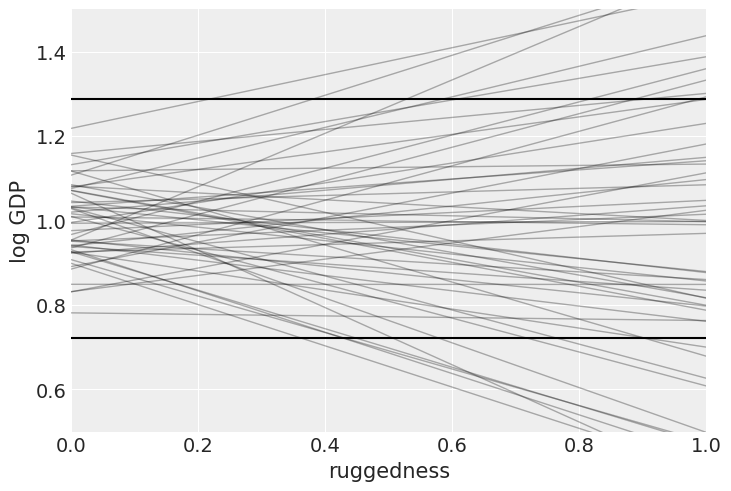

In [ ]:
n = 50
rugged_plot = np.linspace(-0.1, 1.1, num=n)
plt.plot(
    rugged_plot,
    prior_m8_1["a"][:n] + prior_m8_1["b"][:n] * rugged_plot.reshape(-1, 1),
    color="k",
    lw=1,
    alpha=0.3
)

plt.hlines(y=min(dd.log_gdp_std), xmin=-0.1, xmax=1.1)
plt.hlines(y=max(dd.log_gdp_std), xmin=-0.1, xmax=1.1)

plt.xlim([0,1])
plt.ylim([0.5, 1.5])
plt.xlabel('ruggedness')
plt.ylabel('log GDP')

plt.show()

### Code 8.7

In [ ]:
#make variable to index Africa (1) or not (2)
dd['cid'] = pd.Categorical(dd["cont_africa"])

### Code 8.8

In [ ]:
with pm.Model() as m8_2:
  sigma = pm.Exponential('sigma', 1)
  b = pm.Normal('b', 0, 0.3)
  a = pm.Normal('a', 1, 0.1, shape=2)
  mu = a[dd['cid']] + b*(dd.rugged_std - 0.215)
  log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=dd.log_gdp_std)

  m8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Code 8.9

In [ ]:
az.compare({'m8_1':m8_1_trace, 'm8_2':m8_2_trace}, scale='deviance', ic='waic')

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank     waic   p_waic   d_waic  ...       se      dse warning waic_scale
m8_2    0  -252.27  4.13084        0  ...  12.7381        0    True   deviance
m8_1    1 -188.689  2.62917  63.5811  ...  14.5226  14.6413   False   deviance

[2 rows x 9 columns]

### Code 8.10

In [ ]:
precis(m8_2_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
b     -0.05  0.05     -0.12       0.03
a[0]   1.05  0.01      1.03       1.07
a[1]   0.88  0.02      0.85       0.90
sigma  0.11  0.01      0.10       0.12

### Code 8.11

In [ ]:
with m8_2:
  post = pm.sample_posterior_predictive(m8_2_trace, vars=[a, b])

In [ ]:
diff_a1_a2 = post['a'][:,0] - post['a'][:,1]
az.hdi(diff_a1_a2, hdi_prob=0.89)

array([0.13932946, 0.19922764])

### Code 8.12

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


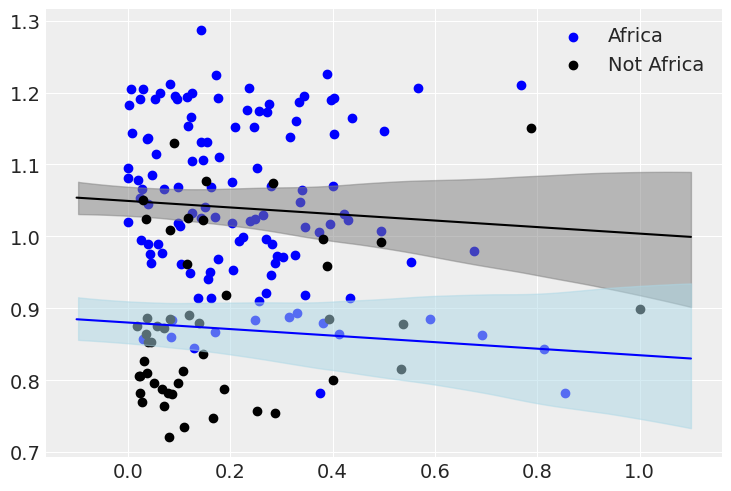

In [ ]:
rugged_seq = np.linspace(-0.1, 1.1, num=30)
_, ax = plt.subplots()

#compute mu over samples, fixing cid=2
plt.scatter(x=dd.loc[dd.cid==0, 'rugged_std'],
            y= dd.loc[dd.cid==0, 'log_gdp_std'],
            color='b',
            label='Africa')
pred0 = (post['a'][:,0] + rugged_seq.reshape(-1, 1) * post['b'])
ax.plot(rugged_seq, pred0.mean(1), color='k')
az.plot_hdi(rugged_seq, pred0.T, ax=ax, color='grey')


ax.scatter(x=dd.loc[dd.cid==1, 'rugged_std'],
            y= dd.loc[dd.cid==1, 'log_gdp_std'],
            color='k',
            label='Not Africa')
pred1 = (post['a'][:,1] + rugged_seq.reshape(-1, 1) * post['b'])
ax.plot(rugged_seq, pred1.mean(1), color='b')
az.plot_hdi(rugged_seq, pred1.T, ax=ax, color='lightblue')


plt.legend()
plt.show()

### Code 8.13

In [ ]:
with pm.Model() as m8_3:
  sigma = pm.Exponential('sigma', 1)
  b = pm.Normal('b', 0, 0.3, shape=2)
  a = pm.Normal('a', 1, 0.1, shape=2)
  mu = a[dd['cid']] + b[dd.cid]*(dd.rugged_std - 0.215)
  log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=dd.log_gdp_std)

  m8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


### Code 8.14

In [ ]:
precis(m8_3_trace)

### Code 8.15

In [ ]:
az.compare({'m8.1':m8_1_trace, 'm8.2':m8_2_trace, 'm8.3':m8_3_trace}, scale='deviance', ic='loo')

### Code 8.16

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


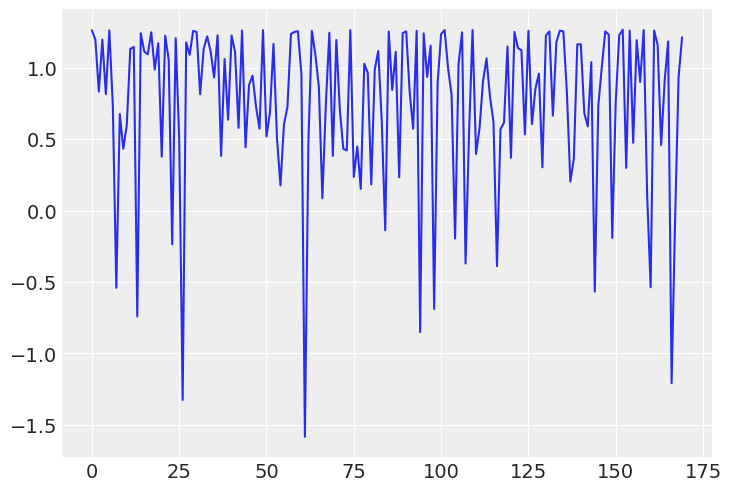

In [ ]:
m8_3_loo = az.loo(m8_3_trace, pointwise=True)

plt.plot(m8_3_loo.loo_i)

### Code 8.17

In [ ]:
with m8_3:
  post8_3 = pm.sample_posterior_predictive(m8_3_trace, vars=[a,b])

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


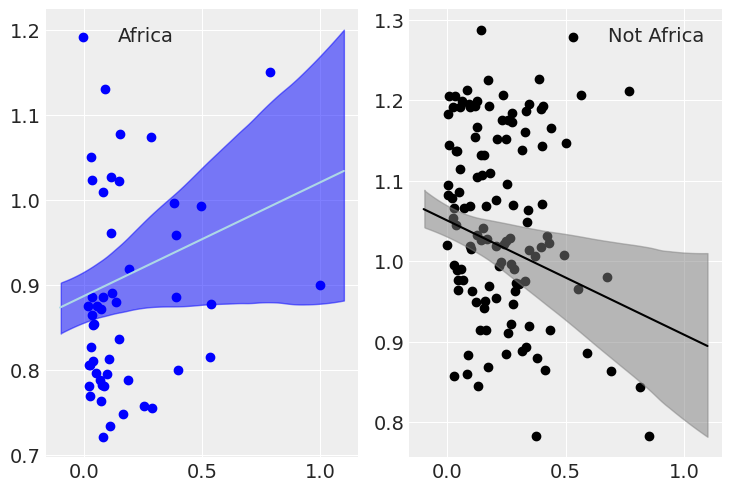

In [ ]:
# African Nations
_, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x=dd.loc[dd.cid==1, 'rugged_std'],
            y= dd.loc[dd.cid==1, 'log_gdp_std'],
            color='b',
            label='Africa')
pred0 = (post8_3['a'][:,1] + rugged_seq.reshape(-1, 1) * post8_3['b'][:,1])
ax1.plot(rugged_seq, pred0.mean(1), color='lightblue')
az.plot_hdi(rugged_seq, pred0.T, ax=ax1, color='b')

ax2.scatter(x=dd.loc[dd.cid==0, 'rugged_std'],
            y= dd.loc[dd.cid==0, 'log_gdp_std'],
            color='k',
            label='Not Africa')

pred1 = (post8_3['a'][:,0] + rugged_seq.reshape(-1, 1) * post8_3['b'][:,0])
ax2.plot(rugged_seq, pred0.mean(1), color='k')
az.plot_hdi(rugged_seq, pred1.T, ax=ax2, color='grey')

ax1.legend()
ax2.legend()
plt.show()

### Code 8.18

In [ ]:
rugged_seq = np.linspace(-0.2, 1.2, 30)

In [ ]:
with m8_3:
  post8_3 = pm.sample_posterior_predictive(m8_3_trace, vars=[a,b])

muA = post8_3['a'][:, 1] + rugged_seq.reshape(-1, 1) * post8_3['b'][:, 1]
muN = post8_3['a'][:, 0] + rugged_seq.reshape(-1, 1) * post8_3['b'][:, 0]

delta = muA - muN

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


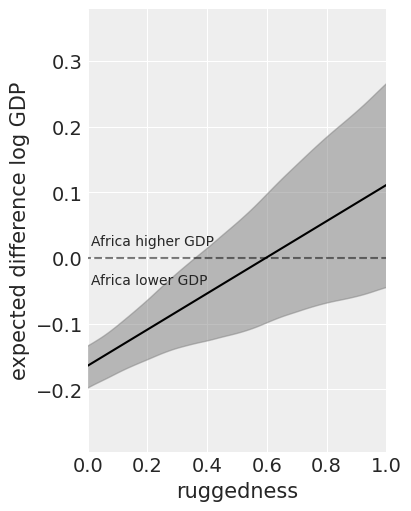

In [ ]:
# Fig 8.6
_, ax = plt.subplots(figsize=[4, 5])
ax.plot(rugged_seq, delta.mean(1), color='k')
az.plot_hdi(x=rugged_seq.T, y=delta.T, hdi_prob=0.89, ax=ax, color='grey')
ax.hlines(0, min(rugged_seq), max(rugged_seq), linestyles='--', alpha=0.5)
plt.text(0.01, 0.02, 'Africa higher GDP')
plt.text(0.01, -0.04, 'Africa lower GDP')
ax.set_ylabel('expected difference log GDP')
ax.set_xlabel('ruggedness')
plt.xlim([0, 1])
plt.show()

## 8.3 Continuous interactions

### Code 8.19

In [ ]:
d = pd.read_csv(BASE_URL + '/tulips.csv', sep=';')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bed     27 non-null     object 
 1   water   27 non-null     int64  
 2   shade   27 non-null     int64  
 3   blooms  27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


In [ ]:
d.describe()

water     shade      blooms
count  27.00000  27.00000   27.000000
mean    2.00000   2.00000  128.993704
std     0.83205   0.83205   92.683923
min     1.00000   1.00000    0.000000
25%     1.00000   1.00000   71.115000
50%     2.00000   2.00000  111.040000
75%     3.00000   3.00000  190.300000
max     3.00000   3.00000  361.660000

### Code 8.20

In [ ]:
d['blooms_std'] = d['blooms'] / max(d['blooms'])
d['water_cent'] = d['water'] - d['water'].mean()
d['shade_cent'] = d['shade'] - d['shade'].mean()

### Code 8.21

In [ ]:
a = np.random.normal(0.5, 1, 10000)
sum(np.array([(i < 0) | (i > 1) for i in a])) / len(a)

0.6183

### Code 8.22

In [ ]:
a = np.random.normal(0.5, 0.25, 10000)
sum(np.array([(i < 0) | (i > 1) for i in a])) / len(a)

0.0485

### Code 8.23

In [ ]:
with pm.Model() as m8_4:
  sigma = pm.Exponential('sigma', 1)
  bs = pm.Normal('bs', 0, 0.25)
  bw = pm.Normal('bw', 0, 0.25)
  a = pm.Normal('a', 0.5, 0.25)
  mu = a + bw*d.water_cent + bs*d.shade_cent
  blooms_std = pm.Normal('blooms_std', mu, sigma, observed=d.blooms_std)

  m8_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, bw, bs, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [ ]:
with m8_4:
  m8_4_post = pm.sample_posterior_predictive(
        m8_4_trace, var_names=["a", "bw", "bs"]
  )

In [ ]:
precis(m8_4_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
bs    -0.16  0.03     -0.20      -0.11
bw     0.16  0.03      0.11       0.20
a      0.52  0.24      0.14       0.90
sigma  0.18  0.02      0.15       0.22

### Code 8.24

In [ ]:
with pm.Model() as m8_5:
  a = pm.Normal('a', 0.5, 0.25)
  bw = pm.Normal('bw', 0, 0.25)
  bs = pm.Normal('bs', 0, 0.25)
  bws = pm.Normal('bws', 0, 0.25)
  sigma = pm.Exponential('sigma', 1)
  mu = a + bw*d.water_cent + bs*d.shade_cent + bws*d.water_cent*d.shade_cent
  blooms_std = pm.Normal('blooms_std', mu, sigma, observed=d.blooms_std)

  m8_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bws, bs, bw, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Code 8.25

In [ ]:
with m8_5:
  m8_5_post = pm.sample_posterior_predictive(
        m8_5_trace, var_names=["a", "bw", "bs", "bws"]
  )

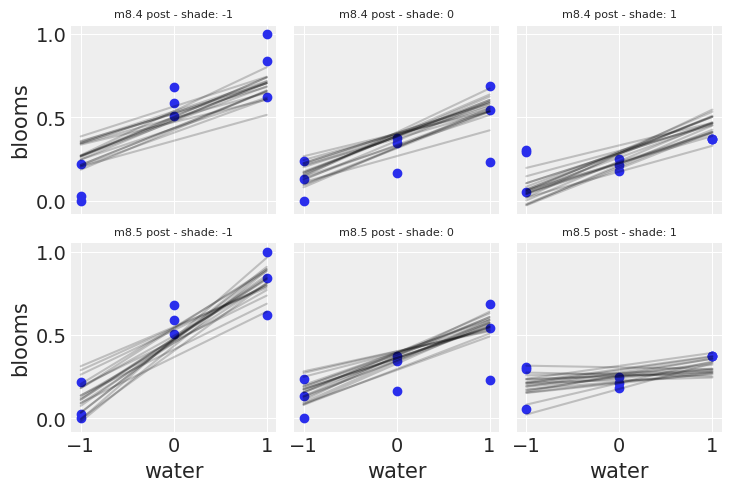

In [ ]:
#Figure 8.7
_, axs = plt.subplots(2, 3, sharey=True, sharex=True)
n_lines = 20
x_pred = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
  idx = d.shade_cent == shade
  for ax in axs[:, i]:
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])

  #top axis
  ax = axs[0, i]
  y_pred = (m8_4_post['a'][:n_lines]
          + m8_4_post['bs'][:n_lines]*shade
          + m8_4_post['bw'][:n_lines]*x_pred.reshape(-1, 1)
          )
  ax.plot(x_pred, y_pred, color='k', alpha=0.2)
  ax.set_title('m8.4 post - shade: {}'.format(shade), fontsize=8)

  #bottom axis
  ax = axs[1, i]
  y_pred = (m8_5_post['a'][:n_lines]
          + m8_5_post['bs'][:n_lines]*shade
          + m8_5_post['bw'][:n_lines] *x_pred.reshape(-1, 1)
          + m8_5_post['bws'][:n_lines] *x_pred.reshape(-1, 1) * shade
          )
  ax.plot(x_pred, y_pred, color='k', alpha=0.2)
  ax.set_title('m8.5 post - shade: {}'.format(shade), fontsize=8)

for ax in axs.flat:
  if ax.is_first_col():
    ax.set_ylabel('blooms')
  if ax.is_last_row():
    ax.set_xlabel('water')

### Code 8.26

In [ ]:
np.random.seed(7)
with m8_4:
  m8_4_prior = pm.sample_prior_predictive(vars=['a', 'bs', 'bw'])

with m8_5:
  m8_5_prior = pm.sample_prior_predictive(vars=['a', 'bs', 'bw', 'bws'])

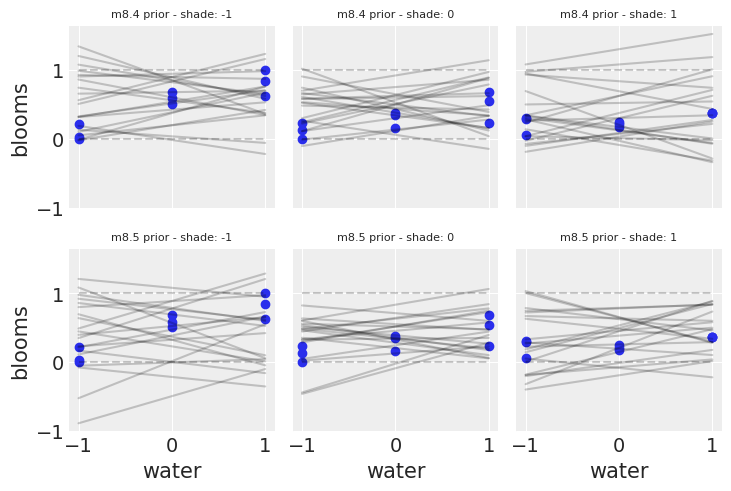

In [ ]:
#Figure 8.7
_, axs = plt.subplots(2, 3, sharey=True, sharex=True)
n_lines = 20
x_pred = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
  idx = d.shade_cent == shade
  for ax in axs[:, i]:
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.hlines([0, 1], -1, 1, alpha=0.2, linestyle='--')
    #ax.hlines(0, -1, 1, alpha=0.2, linestyle='--')

  #top axis
  ax = axs[0, i]
  y_pred = (m8_4_prior['a'][:n_lines]
          + m8_4_prior['bs'][:n_lines]*shade
          + m8_4_prior['bw'][:n_lines]*x_pred.reshape(-1, 1)
          )
  ax.plot(x_pred, y_pred, color='k', alpha=0.2)
  ax.set_title('m8.4 prior - shade: {}'.format(shade), fontsize=8)


  #bottom axis
  ax = axs[1, i]
  y_pred = (m8_5_prior['a'][:n_lines]
          + m8_5_prior['bs'][:n_lines]*shade
          + m8_5_prior['bw'][:n_lines] *x_pred.reshape(-1, 1)
          + m8_5_prior['bws'][:n_lines] *x_pred.reshape(-1, 1) * shade
          )
  ax.plot(x_pred, y_pred, color='k', alpha=0.2)
  ax.set_title('m8.5 prior - shade: {}'.format(shade), fontsize=8)

for ax in axs.flat:
  if ax.is_first_col():
    ax.set_ylabel('blooms')
  if ax.is_last_row():
    ax.set_xlabel('water')

# Chapter 9

Lecture 10: https://www.youtube.com/watch?v=v-j0UmWf3Us&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=10&ab_channel=RichardMcElreath

All Credits go to: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb

## 9.1 Good King Markov and his island kingdom

### Code 9.1

In [ ]:
num_weeks = int(1e5)
positions = np.repeat(0, num_weeks)
current = 10
for i in range(1, num_weeks):
  ## record current position
  positions[i] = current

  ##flip coin to generate proposal
  proposal = current + np.random.choice([-1, 1])

  ## now make sure he loops around the archipelago
  if (proposal < 1):
    proposal = 10
  elif proposal > 10:
    proposal = 1
  
  ## move?
  prop_move = proposal / current

  if np.random.uniform() < prop_move:
    current = proposal
  else:
    current = current

### Code 9.2

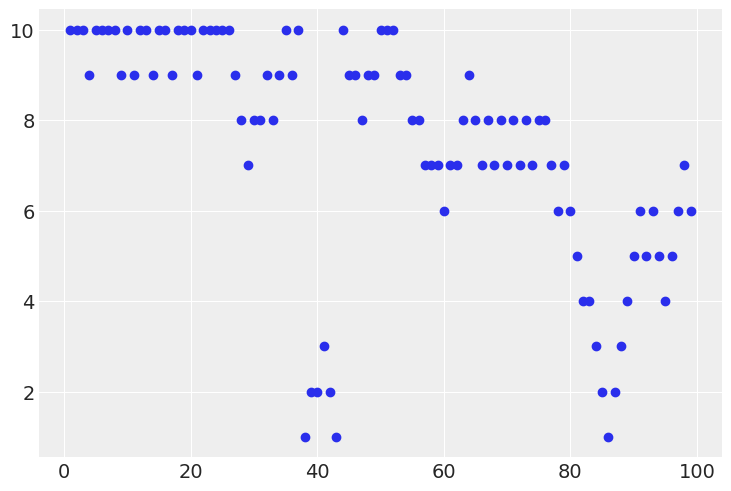

In [ ]:
pos = np.arange(1, 100)
plt.plot(pos, positions[pos], marker='o', linewidth=0)

### Code 9.3

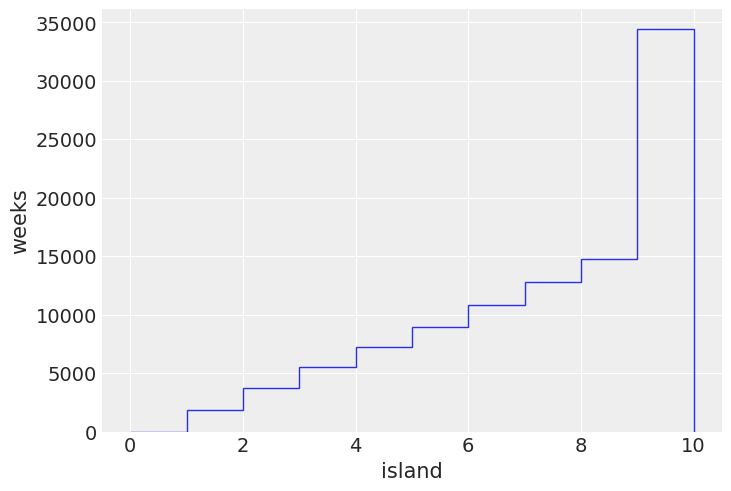

In [ ]:
plt.hist(positions, histtype='step')
plt.ylabel('weeks')
plt.xlabel('island')
plt.show()

## 9.2 Metropolis algorithms

### Code 9.4

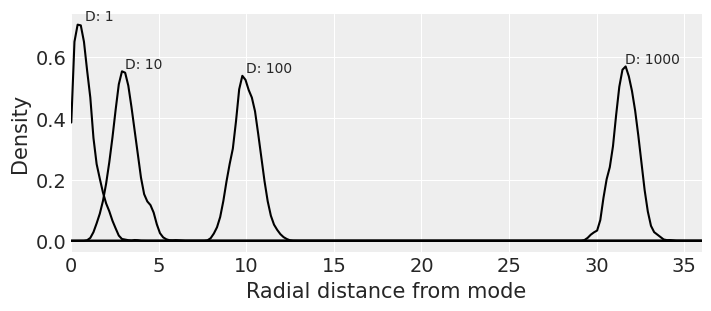

In [ ]:
#Figure 9.4
def rad_dist(Y):
    return np.sqrt(np.sum(Y ** 2))


fig, ax = plt.subplots(1, 1, figsize=[7, 3])
xvar = np.linspace(0, 36, 200)

# the book code is wrapped in a loop to reproduce Figure 9.4
for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)

    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="k")

    ax.text(np.mean(Rd), np.max(yvar) * 1.02, f"D: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density");

## 9.3. Hamiltonian Monte Carlo

## 9.4 Easy HMC: ulam

### Code 9.11

In [ ]:
d = pd.read_csv(BASE_URL + '/rugged.csv', sep=';')
# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)
# extract countries with GDP data
dd = d.dropna(subset=['rgdppc_2000']).copy()
# rescale variables
dd['log_gdp_std'] = dd['log_gdp'] / dd['log_gdp'].mean()
dd['rugged_std'] = dd['rugged'] / dd['rugged'].max()

#cid = pd.Categorical([1 if i==1 else 2 for i in dd.cont_africa])
cid = pd.Categorical(dd.cont_africa)
dd['cid'] = cid
dd.head()

isocode  isonum               country  ...  log_gdp_std  rugged_std  cid
2     AGO      24                Angola  ...     0.879712    0.138342    1
4     ALB       8               Albania  ...     0.964755    0.552564    0
7     ARE     784  United Arab Emirates  ...     1.166270    0.123992    0
8     ARG      32             Argentina  ...     1.104485    0.124960    0
9     ARM      51               Armenia  ...     0.914904    0.433409    0

[5 rows x 55 columns]

### Code 9.12

In [ ]:
with pm.Model() as m8_3:
  a = pm.Normal('a', 1, 0.1, shape=cid.categories.size)
  b = pm.Normal('b', 0, 0.3, shape=cid.categories.size)
  sigma = pm.Exponential('sigma', 1)
  mu = a[dd.cid] + b[dd.cid] * (dd.rugged_std - 0.215)
  log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=dd.log_gdp_std)

  m8_3_trace = pm.sample()

In [ ]:
precis(m8_3_trace)

In [ ]:
az.summary(m8_3_trace, kind="all", round_to=2)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_3%  hdi_97%  ...   ess_sd  ess_bulk  ess_tail  r_hat
a[0]   1.05  0.01    1.03     1.07  ...  3602.60   3589.30   1698.30    1.0
a[1]   0.89  0.02    0.86     0.92  ...  2744.86   2748.91   1525.30    1.0
b[0]  -0.14  0.06   -0.24    -0.03  ...  2546.57   3159.45   1477.51    1.0
b[1]   0.13  0.07   -0.01     0.27  ...  2381.10   3937.90   1425.64    1.0
sigma  0.11  0.01    0.10     0.12  ...  3232.25   3244.00   1609.69    1.0

[5 rows x 11 columns]

### Code 9.19

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


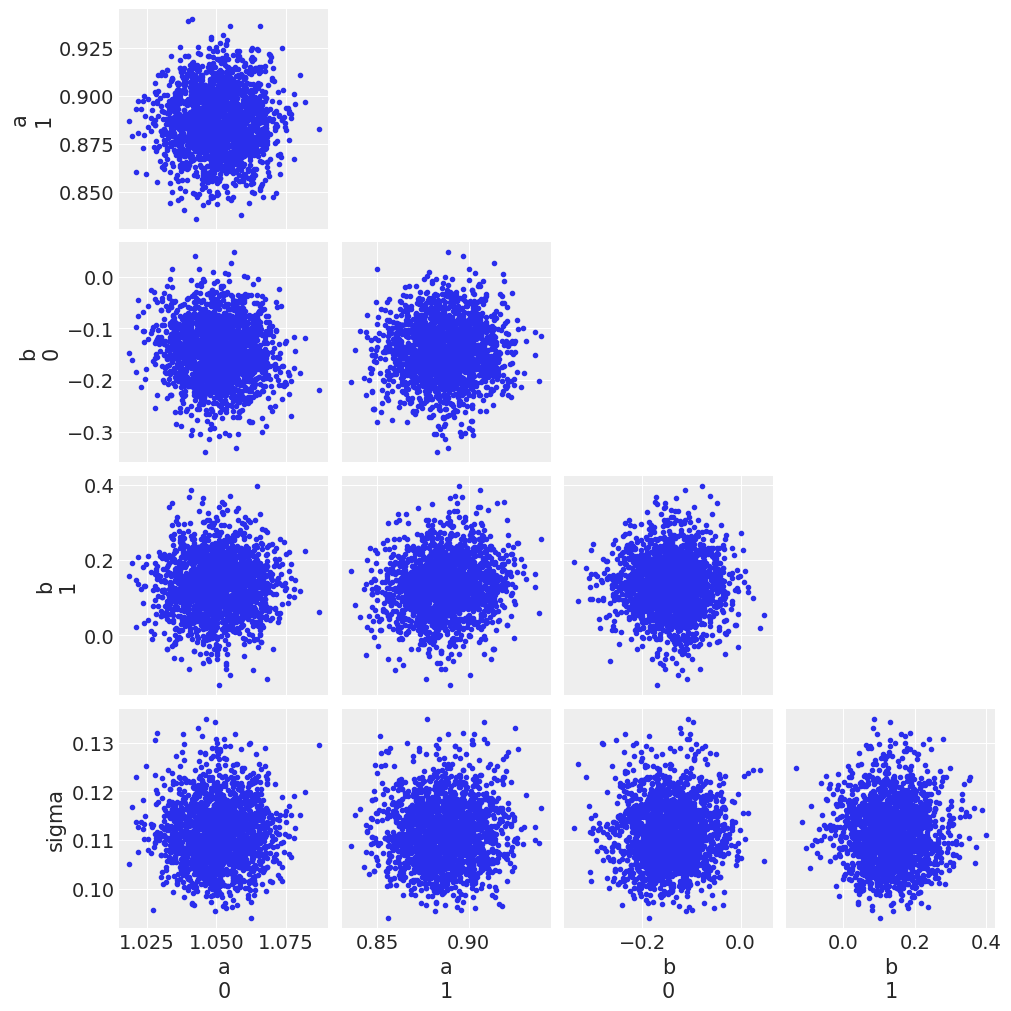

In [ ]:
az.plot_pair(m8_3_trace, figsize=[10, 10])
plt.show()

### Code 9.20

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


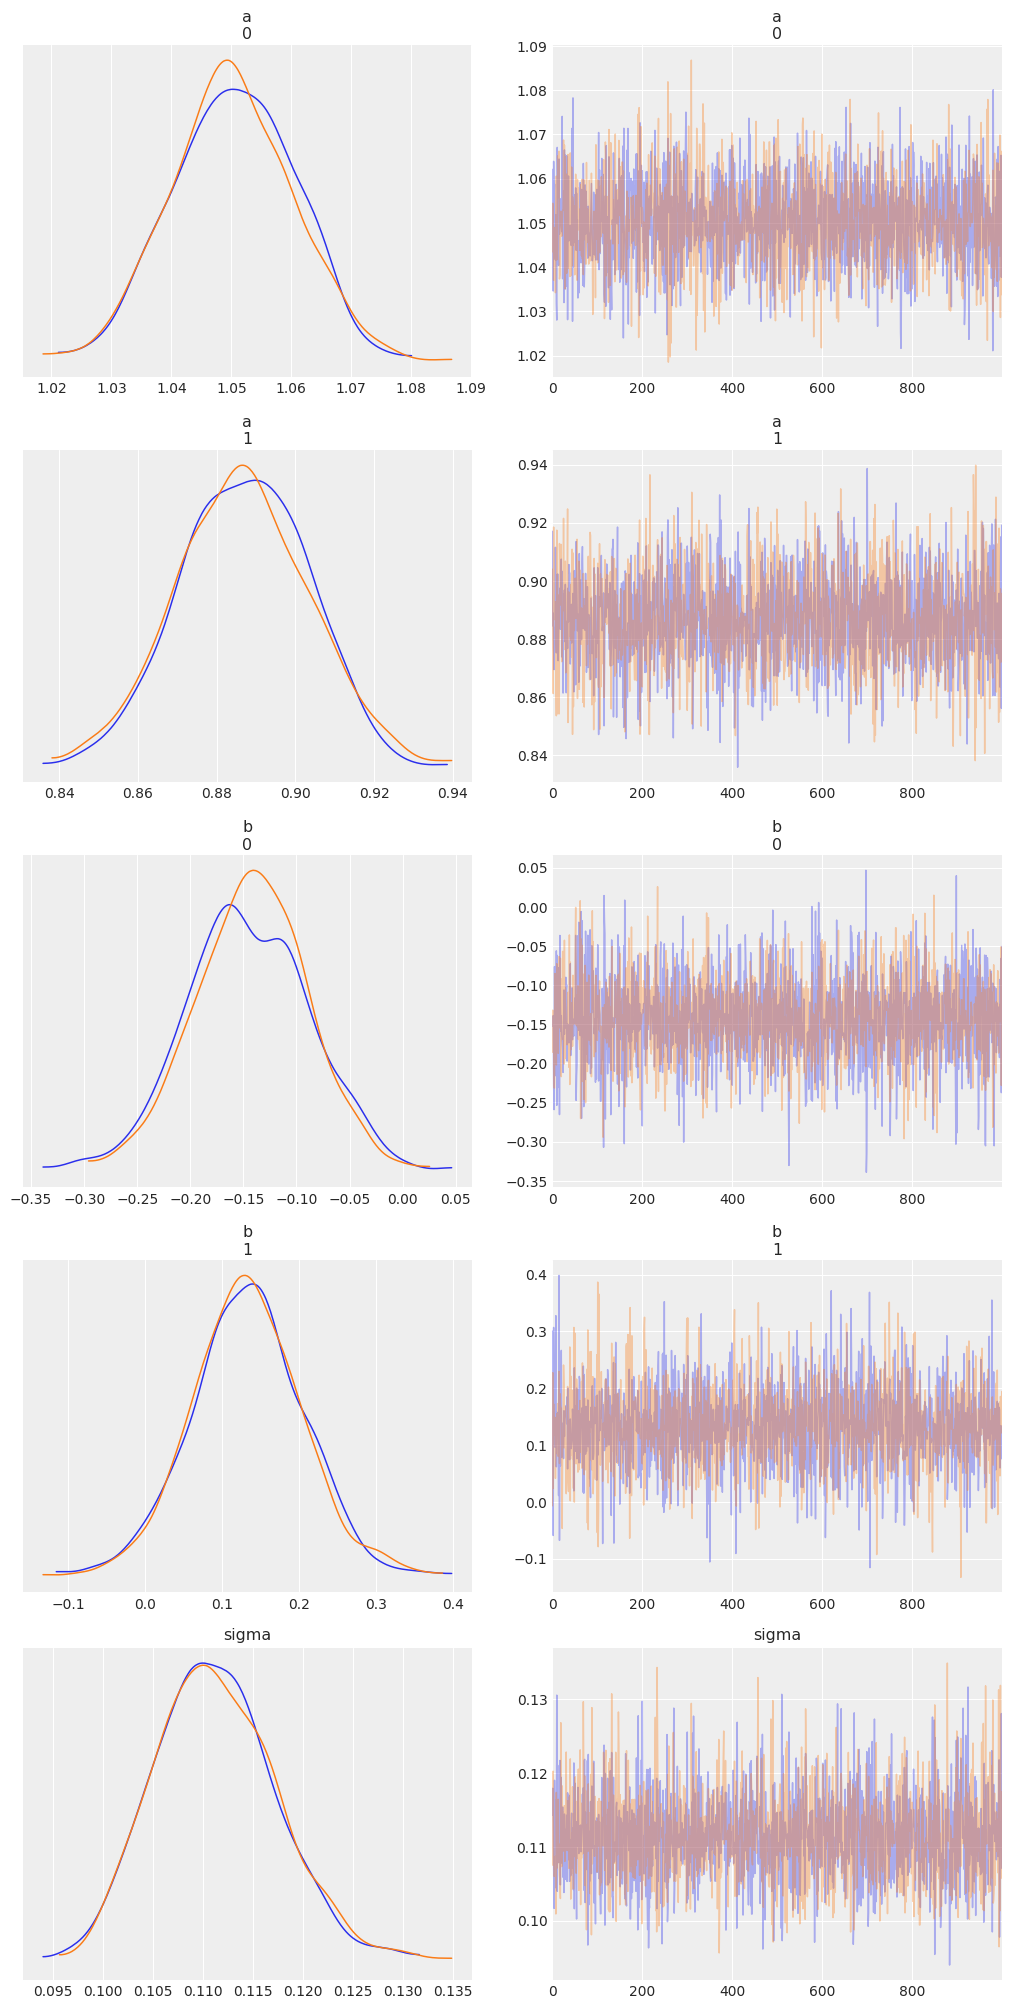

In [ ]:
az.plot_trace(m8_3_trace, figsize=[10, 20])
plt.show()

## 9.5 Care and feeding of your Markov chain

### Code 9.22

In [ ]:
y = np.array([-1, 1])

with pm.Model() as m9_2:

  sigma = pm.Exponential('sigma', 0.0001)
  alpha = pm.Normal('alpha', 0, 1000)
  mu = alpha
  y = pm.Normal('y', mu, sigma, observed=y)

  m9_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6497100585977147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6301796088726773, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
az.summary(m9_2_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        sd   hdi_3%   hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
alpha   27.210   417.444 -756.575   994.279  ...   249.0     330.0     333.0   1.01
sigma  704.602  1561.951    9.067  2355.442  ...   281.0      67.0      34.0   1.01

[2 rows x 11 columns]

### Figure 9.9

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa0ca12e80>,
      dtype=object)

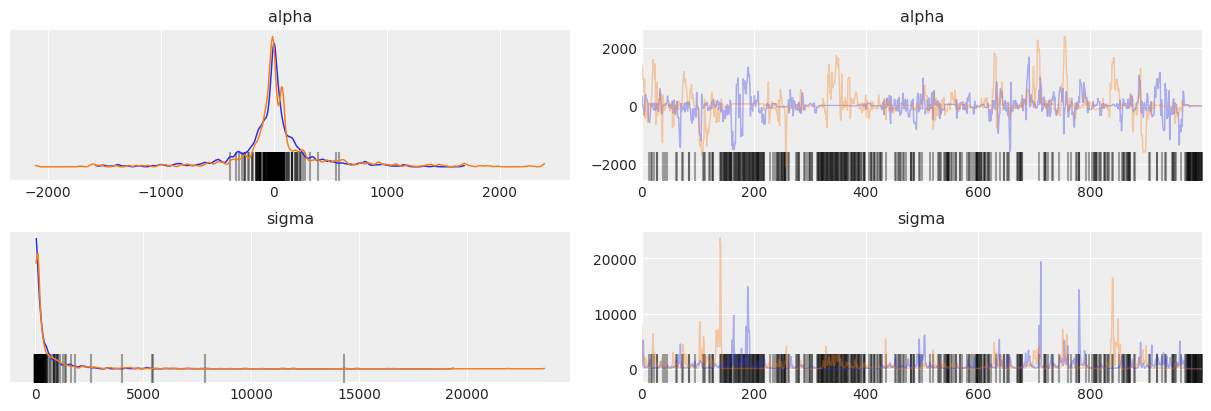

In [ ]:
az.plot_trace(m9_2_trace)

### Code 9.24

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9fdf44630>,
      dtype=object)

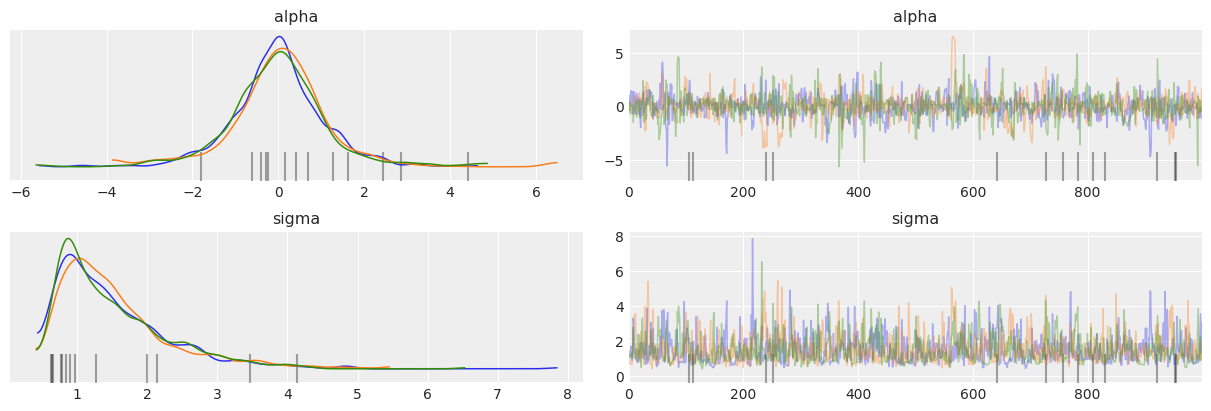

In [ ]:
y = np.array([-1, 1])

with pm.Model() as m9_3:

  sigma = pm.Exponential('sigma', 1)
  alpha = pm.Normal('alpha', 1, 10)
  mu = alpha
  y = pm.Normal('y', mu, sigma, observed=y)

  m9_3_trace = pm.sample(chains=3)

az.plot_trace(m9_3_trace)

### Code 9.25

In [ ]:
y = np.random.normal(0, 1, 100)

### Code 9.26

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [a1, a2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 363 seconds.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31263221385490664, but should be close to 0.8. Try to increase the number of tuning steps.
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42484623039592356, but should be close to 0.8. Try to increase the number of tuning steps.
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_p

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9fdb179b0>,
      dtype=object)

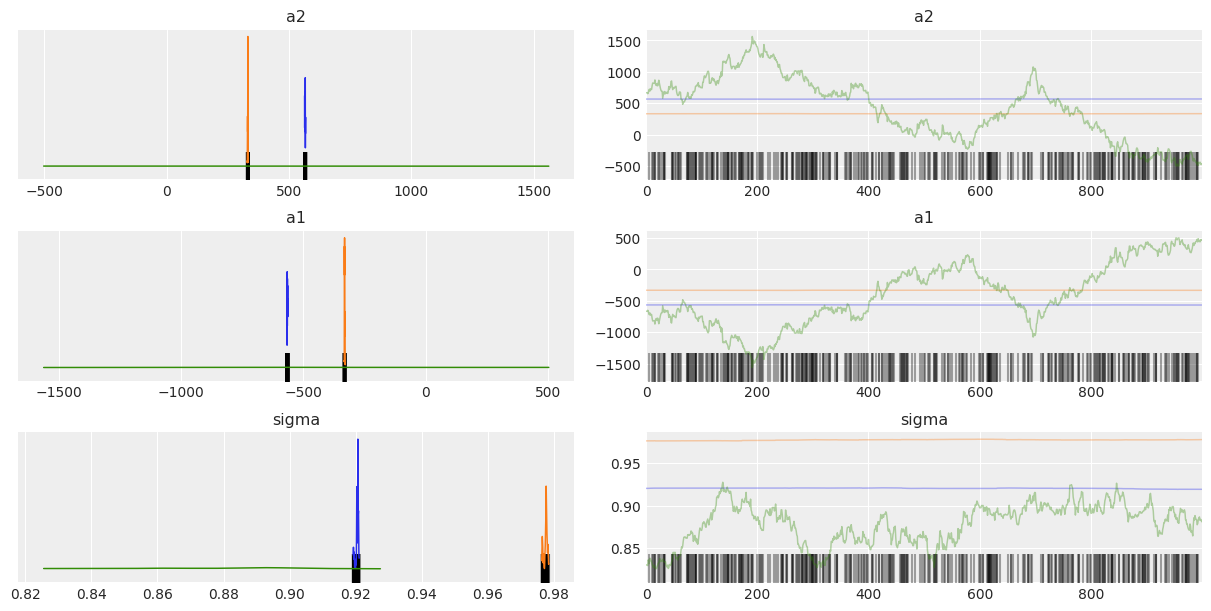

In [ ]:
with pm.Model() as m9_4:
  sigma = pm.Exponential('sigma', 1)
  a2 = pm.Normal('a2', 0, 1000)
  a1 = pm.Normal('a1', 0, 1000)
  mu = a1 + a2
  y = pm.Normal('y', mu, sigma, observed=y)

  m9_4_trace = pm.sample(chains=3)

az.plot_trace(m9_4_trace)

### Code 9.26

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [a1, a2, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 121 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9fc870208>,
      dtype=object)

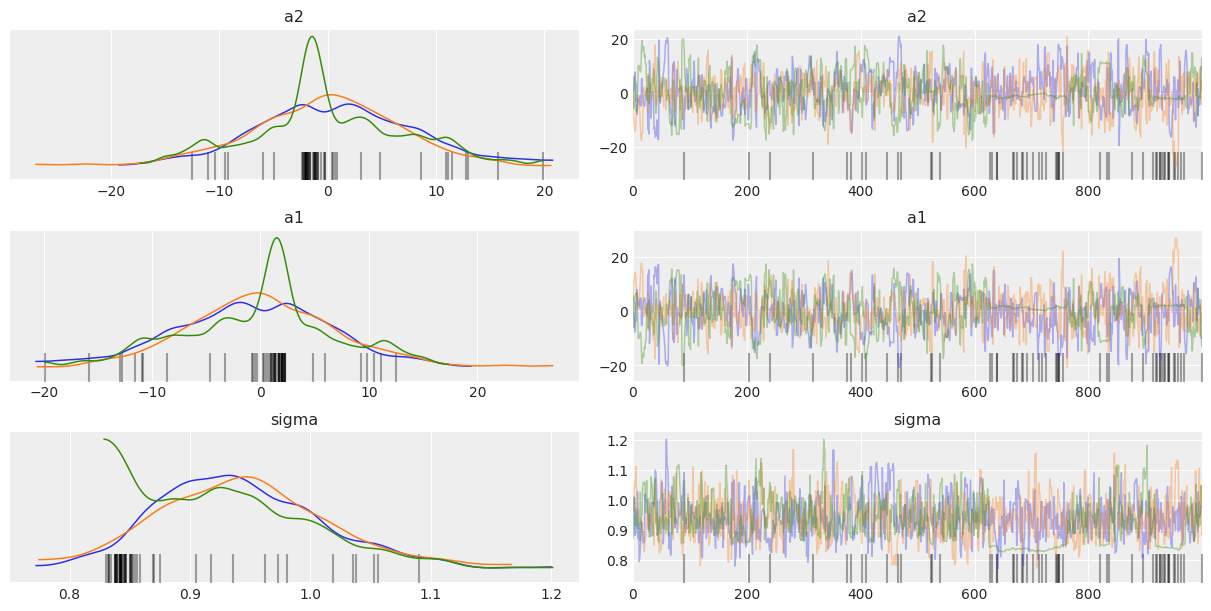

In [ ]:
y = np.random.normal(0, 1, 100)
with pm.Model() as m9_5:
  sigma = pm.Exponential('sigma', 1)
  a2 = pm.Normal('a2', 0, 10)
  a1 = pm.Normal('a1', 0, 10)
  mu = a1 + a2
  y = pm.Normal('y', mu, sigma, observed=y)

  m9_5_trace = pm.sample(chains=3)

az.plot_trace(m9_5_trace)

In [ ]:
az.summary(m9_5_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
a2     0.244  7.143 -14.058   13.066  ...   425.0     591.0     794.0   1.03
a1    -0.202  7.140 -12.958   14.192  ...   426.0     592.0     788.0   1.03
sigma  0.938  0.071   0.824    1.074  ...   226.0     176.0     283.0   1.03

[3 rows x 11 columns]

# Homework

Homework: https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week05.pdf

Solutions: https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week05_solutions.pdf

Py Solution: https://github.com/gbosquechacon/statrethink_course_in_pymc3/blob/master/notebooks/pymc3/rethink_stats_pymc3_w05.ipynb

## 1 Load Data

In [5]:
d = pd.read_csv(BASE_URL + '/Wines2012.csv', sep=';')

In [6]:
S =  scale(d.score),
jid = pd.Categorical(d.judge).codes
wid = pd.Categorical(d.wine).codes

In [7]:
with pm.Model() as m1:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5, shape=len(np.unique(jid)))
  w = pm.Normal('w', 0, 0.5, shape=len(np.unique(wid)))
  mu = a[jid] + w[wid]
  S = pm.Normal('S', mu, sigma, observed=S)

  m1_trace = pm.sample(chains = 4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [32]:
with m1:
  prior = pm.sample_prior_predictive()
  posterior_1 = pm.sample()
  posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [33]:
data = az.from_pymc3(trace=posterior_1,
                     prior=prior,
                     posterior_predictive=posterior_pred_1)
data

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [35]:
az.summary(m1_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
a[0]  -0.277  0.199  -0.636    0.108  ...  4078.0    5340.0    3311.0    1.0
a[1]   0.212  0.191  -0.155    0.568  ...  3690.0    4666.0    3535.0    1.0
a[2]   0.204  0.199  -0.171    0.568  ...  3346.0    4779.0    3304.0    1.0
a[3]  -0.540  0.193  -0.902   -0.183  ...  4668.0    4821.0    3283.0    1.0
a[4]   0.798  0.196   0.442    1.174  ...  4249.0    4558.0    3194.0    1.0
a[5]   0.477  0.195   0.115    0.836  ...  4125.0    4693.0    3058.0    1.0
a[6]   0.135  0.194  -0.226    0.503  ...  2875.0    4640.0    2990.0    1.0
a[7]  -0.657  0.196  -1.041   -0.294  ...  4094.0    4449.0    2931.0    1.0
a[8]  -0.343  0.194  -0.689    0.025  ...  4413.0    4815.0    3240.0    1.0
w[0]   0.116  0.249  -0.344    0.580  ...  2258.0    5708.0    2935.0    1.0
w[1]   0.082  0.253  -0.414    0.530  ...  2314.0    6049.0    3109.0    1.0
w[2]   0.227  0.257  -0.292    0.679  ...  3076.0    5995.0    2914.0    1.0
w[3]   0.464  0.260  -0.033    0.937  ...  5033.0    6874.0    3198.0    1.0
w[4]  -0.108  0.256  -0.573    0.394  ...  1963.0    6290.0    2940.0    1.0
w[5]  -0.312  0.252  -0.798    0.130  ...  3484.0    5930.0    3214.0    1.0
w[6]   0.244  0.263  -0.241    0.744  ...  3982.0    6061.0    3217.0    1.0
w[7]   0.229  0.258  -0.235    0.721  ...  2772.0    6262.0    2668.0    1.0
w[8]   0.061  0.250  -0.401    0.540  ...  1767.0    5458.0    2781.0    1.0
w[9]   0.107  0.260  -0.413    0.576  ...  2269.0    5886.0    3151.0    1.0
w[10] -0.008  0.263  -0.485    0.506  ...  1675.0    5877.0    2932.0    1.0
w[11] -0.025  0.249  -0.496    0.436  ...  2117.0    5615.0    3221.0    1.0
w[12] -0.091  0.257  -0.593    0.381  ...  2202.0    6189.0    3018.0    1.0
w[13]  0.004  0.247  -0.441    0.485  ...  1840.0    5137.0    2992.0    1.0
w[14] -0.182  0.259  -0.664    0.290  ...  2875.0    6934.0    3114.0    1.0
w[15] -0.170  0.253  -0.646    0.295  ...  2786.0    6556.0    3165.0    1.0
w[16] -0.123  0.254  -0.581    0.375  ...  2509.0    6360.0    3246.0    1.0
w[17] -0.720  0.254  -1.197   -0.233  ...  5165.0    6138.0    2754.0    1.0
w[18] -0.133  0.262  -0.625    0.353  ...  2596.0    6585.0    3015.0    1.0
w[19]  0.319  0.260  -0.180    0.794  ...  3899.0    6083.0    2822.0    1.0
sigma  0.846  0.047   0.756    0.932  ...  6002.0    5822.0    3429.0    1.0

[30 rows x 11 columns]

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9f15777f0>,
      dtype=object)

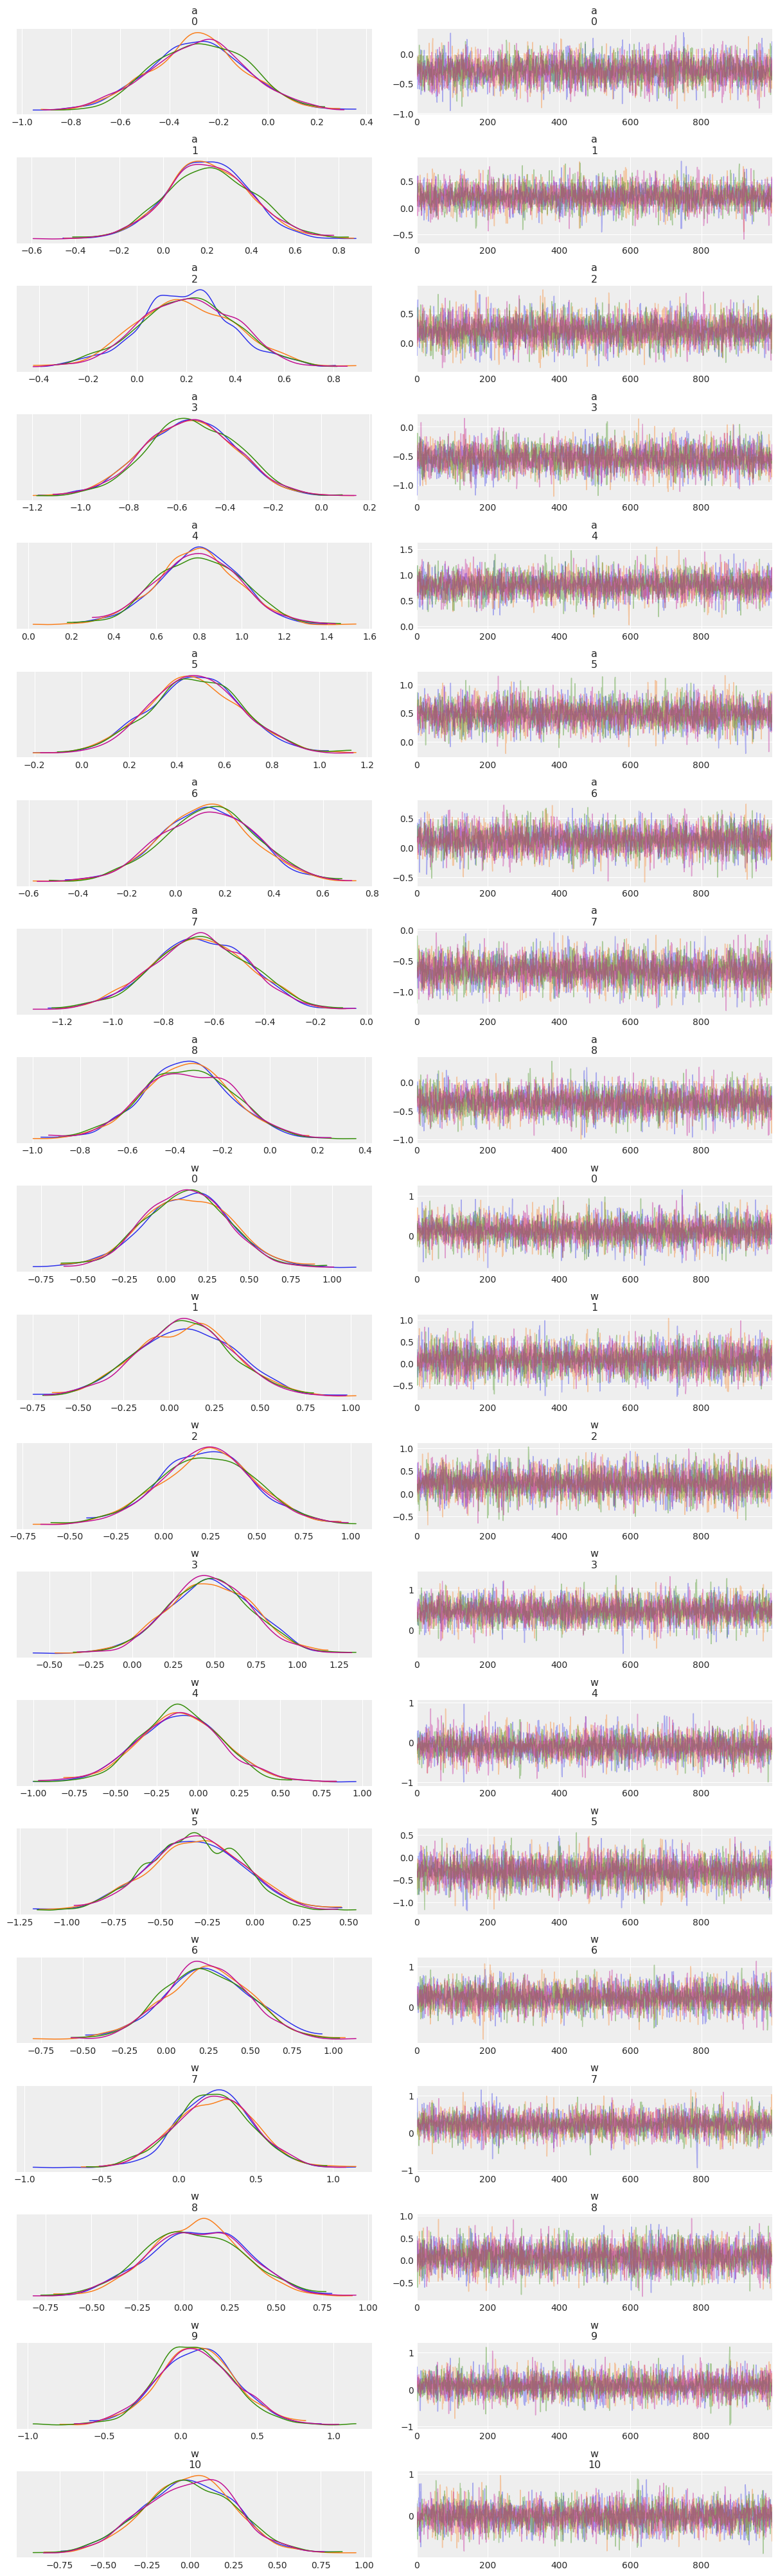

In [ ]:
az.plot_trace(m1_trace)
plt.show()

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb35d9b16a0>],
      dtype=object)

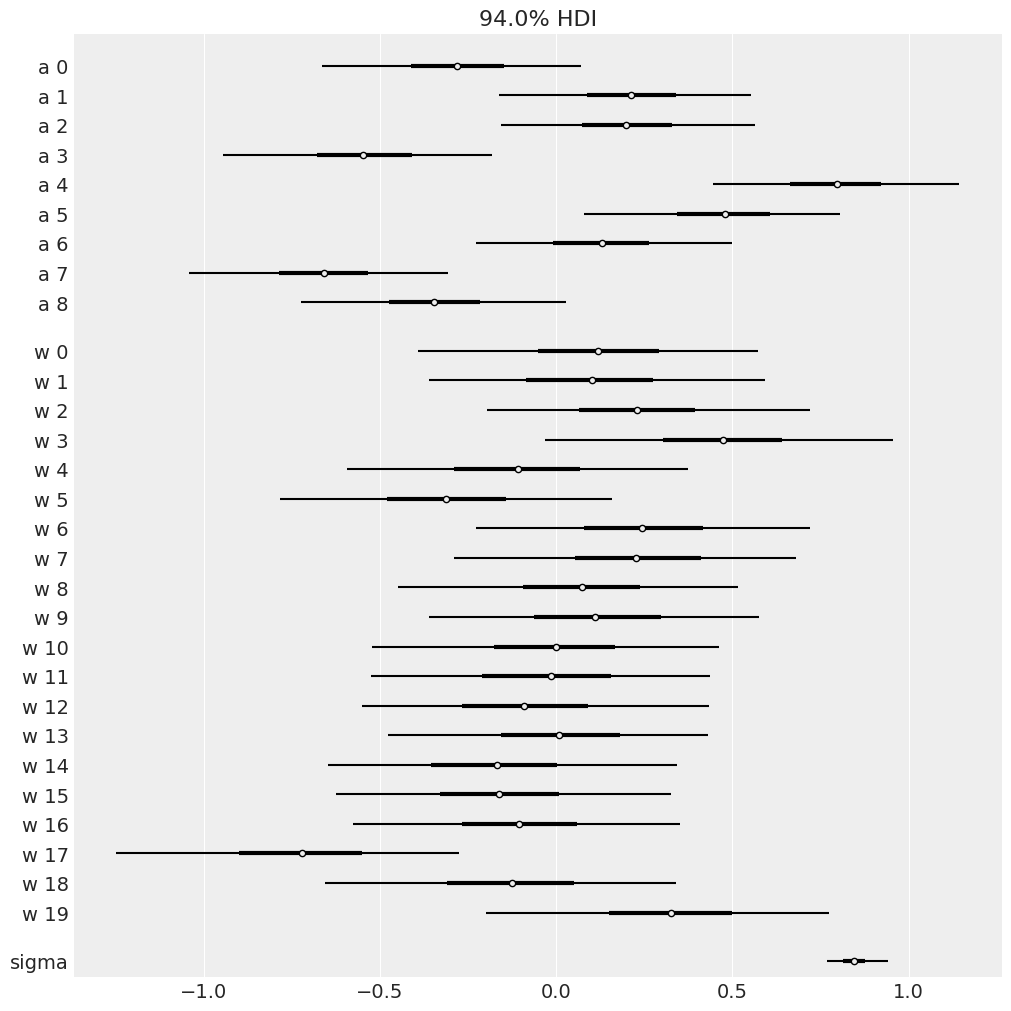

In [39]:
az.style.use('arviz-darkgrid')

az.plot_forest(posterior_1,
                           kind='forestplot',
                           combined=True,
                           ridgeplot_overlap=1,
                           colors='black',
                           figsize=(10, 10))

## 2 Indicators

In [8]:
d.judge.unique()

array(['Jean-M Cardebat', 'Tyler Colman', 'John Foy', 'Olivier Gergaud',
       'Robert Hodgson', 'Linda Murphy', 'Daniele Meulder',
       'Jamal Rayyis', 'Francis Schott'], dtype=object)

In [47]:
S =  scale(d.score),
W = d['wine.amer'].values
J = d['judge.amer'].values
R = pd.Categorical(d['flight']).codes

In [52]:
W

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0])

In [49]:
with pm.Model() as m2:
  bW = pm.Normal('bW', 0, 0.5)
  bJ = pm.Normal('bJ', 0, 0.5)
  bR = pm.Normal('bR', 0, 0.5)

  mu = bW*W + bJ*J + bR*R
  sigma = pm.Exponential('sigma', 1)
  S = pm.Normal('S', mu, sigma, observed=S)

  m2_trace = pm.sample(cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bR, bJ, bW]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb35e2582b0>,
      dtype=object)

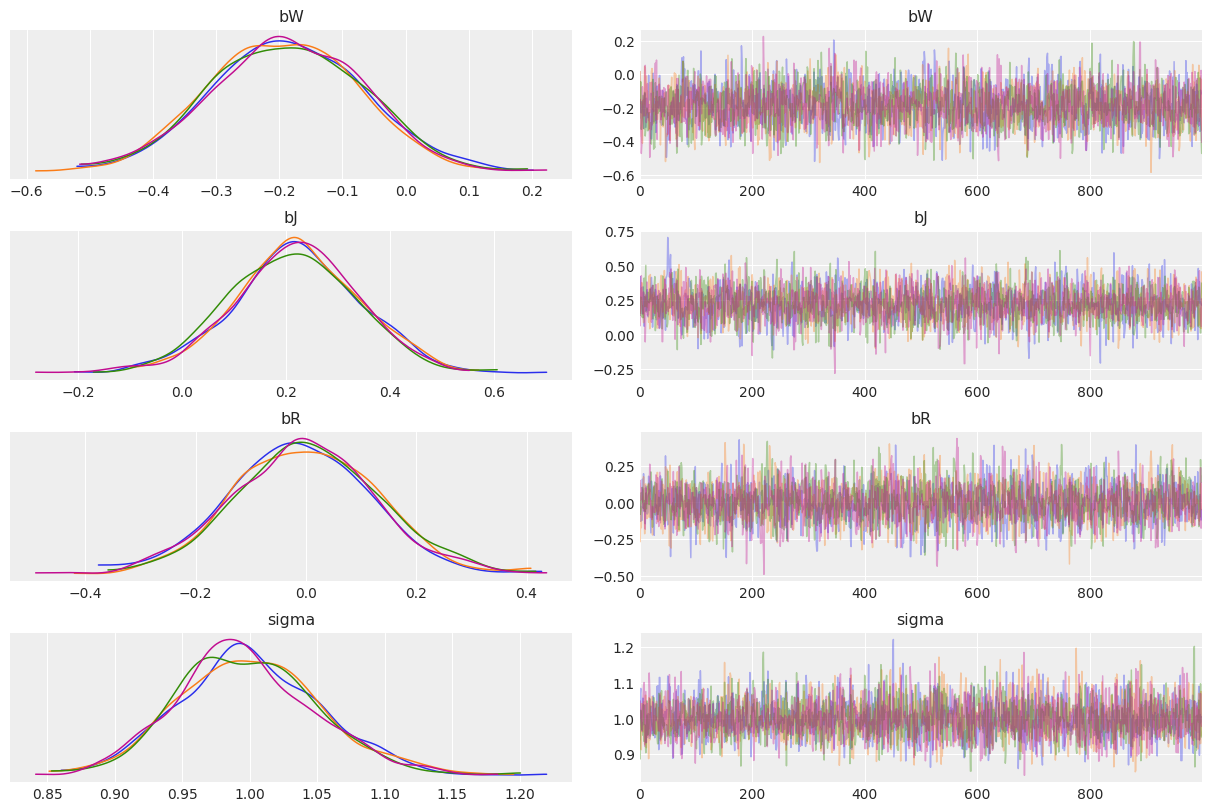

In [50]:
az.plot_trace(m2_trace)

In [51]:
az.summary(m2_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bW    -0.189  0.119  -0.402    0.039  ...  2928.0    2931.0    3095.0    1.0
bJ     0.220  0.121   0.002    0.454  ...  2594.0    2974.0    2897.0    1.0
bR    -0.003  0.129  -0.268    0.224  ...  2069.0    3035.0    2529.0    1.0
sigma  0.999  0.052   0.908    1.102  ...  4032.0    4103.0    2968.0    1.0

[4 rows x 11 columns]

## 3 Interactions

In [57]:
S =  scale(d.score),
W = d['wine.amer'].values
J = d['judge.amer'].values
R = pd.Categorical(d['flight']).codes

with pm.Model() as m3:
  bW = pm.Normal('bW', 0, 0.5)
  bJ = pm.Normal('bJ', 0, 0.5)
  bR = pm.Normal('bR', 0, 0.5)
  
  bRW = pm.Normal('bRW', 0, 0.5)
  bRJ = pm.Normal('bRJ', 0, 0.5)
  bWJ = pm.Normal('bWJ', 0, 0.5)

  mu = bW*W + bJ*J + bR*R + bRW*R*W + bRJ*J*R + bWJ*J*W
  sigma = pm.Exponential('sigma', 1)
  S_hat = pm.Normal('S_hat', mu, sigma, observed=S)

  m3_trace = pm.sample(cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bWJ, bRJ, bRW, bR, bJ, bW]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [54]:
az.summary(m3_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bW    -0.264  0.167  -0.571    0.058  ...  2749.0    2822.0    2570.0    1.0
bJ     0.313  0.183  -0.034    0.663  ...  2417.0    2558.0    2714.0    1.0
bR    -0.159  0.191  -0.489    0.222  ...  2584.0    2618.0    2696.0    1.0
bRW    0.341  0.234  -0.078    0.785  ...  2680.0    2761.0    2883.0    1.0
bRJ   -0.024  0.235  -0.476    0.400  ...  2378.0    2711.0    2664.0    1.0
bWJ   -0.110  0.229  -0.532    0.328  ...  2262.0    2947.0    2628.0    1.0
sigma  0.994  0.052   0.897    1.091  ...  3813.0    3873.0    2875.0    1.0

[7 rows x 11 columns]

In [58]:
with m3:
  m3_posterior_pred = pm.sample_posterior_predictive(m3_trace)

In [61]:
d

judge flight wine  score  wine.amer  judge.amer
0    Jean-M Cardebat  white   A1   10.0          1           0
1    Jean-M Cardebat  white   B1   13.0          1           0
2    Jean-M Cardebat  white   C1   14.0          0           0
3    Jean-M Cardebat  white   D1   15.0          0           0
4    Jean-M Cardebat  white   E1    8.0          1           0
..               ...    ...  ...    ...        ...         ...
175   Francis Schott    red   F2   12.0          1           1
176   Francis Schott    red   G2   15.0          0           1
177   Francis Schott    red   H2   16.0          1           1
178   Francis Schott    red   I2    7.0          1           1
179   Francis Schott    red   J2   17.0          0           1

[180 rows x 6 columns]

In [75]:
d['score_hat'] = ((np.mean(m3_posterior_pred['S_hat'], axis=0)).flatten())

In [76]:
aux = d.groupby(['wine.amer', 'judge.amer','flight'])['score_hat'].mean().reset_index()
aux

wine.amer  judge.amer flight  score_hat
0          0           0    red   0.006211
1          0           0  white  -0.156626
2          0           1    red   0.307538
3          0           1  white   0.114889
4          1           0    red  -0.269287
5          1           0  white  -0.083617
6          1           1    red  -0.063244
7          1           1  white   0.096905

In [79]:
aux['combination'] = (aux['wine.amer'].replace({0:'F', 1:'A'})
 + aux['judge.amer'].replace({0:'F', 1:'A'})
 + aux['flight'].replace({'red':'R', 'white':'W'})
 )

aux

wine.amer  judge.amer flight  score_hat combination
0          0           0    red   0.006211         FFR
1          0           0  white  -0.156626         FFW
2          0           1    red   0.307538         FAR
3          0           1  white   0.114889         FAW
4          1           0    red  -0.269287         AFR
5          1           0  white  -0.083617         AFW
6          1           1    red  -0.063244         AAR
7          1           1  white   0.096905         AAW

In [84]:
combination = pd.factorize(aux['combination'])
score_hat = aux['score_hat']

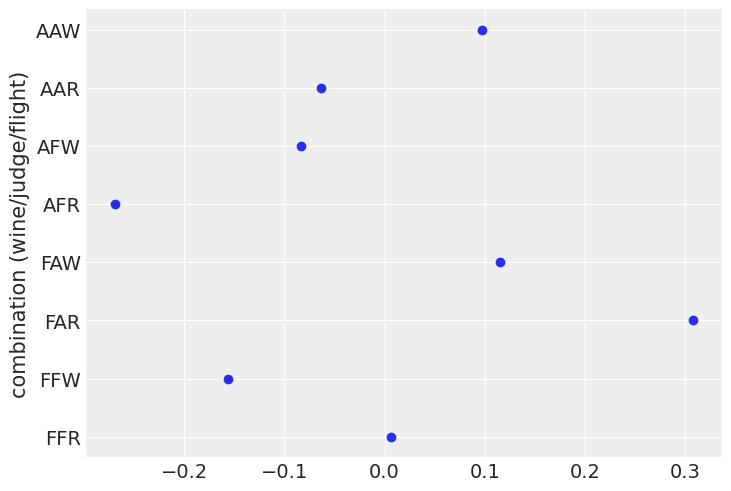

In [90]:
plt.scatter(score_hat, combination[0])
plt.yticks(combination[0], combination[1])
plt.ylabel('combination (wine/judge/flight)')
plt.show()